In [68]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

### Часть 1.

**1. Фильмы ранее 2018 года:**

SELECT title, premiered  
FROM titles  
	JOIN  film_types ON titles.type = film_types.id  
WHERE premiered < 2018 AND film_type = "movie"  

**2. 50 самых популярных фильмов (по кол-ву оценок):**

SELECT title, votes  
FROM rating  
	JOIN titles ON rating.title_id = titles.title_id  
	JOIN  film_types ON titles.type = film_types.id  
WHERE film_type = "movie"  
ORDER BY votes DESC  
LIMIT 50

**3. 10 самых популярных (по кол-ву оценок и с рейтингом >= 7) комедий 2019 года:**

SELECT title, votes, rating, premiered, genre_name  
FROM rating  
	JOIN titles ON rating.title_id = titles.title_id  
	JOIN  film_genres ON rating.title_id = film_genres .title_id  
	JOIN  genre_types ON film_genres.genre_id = genre_types.id  
	JOIN  film_types ON titles.type = film_types.id  
WHERE rating >= 7 AND genre_name = "Comedy" AND premiered = 2019 AND film_type = "movie"  
ORDER BY votes DESC  
LIMIT 10  

**4. С помощью запроса выберите год выхода и название фильмов с кем-то из ваших любимых актеров:**

SELECT title, premiered  
FROM titles   
	JOIN crew ON titles.title_id = crew.title_id  
	JOIN people ON crew.person_id = people.person_id  
	JOIN  film_types ON titles.type = film_types.id  
WHERE name = "Saoirse Ronan" AND film_type = "movie"  

**5. Выберите жанр и посчитайте кол-во фильмов по годам:**

SELECT   
	premiered,  
	COUNT(titles.premiered) as n_films  
FROM titles   
	JOIN  film_genres ON titles.title_id = film_genres .title_id  
	JOIN  genre_types ON film_genres.genre_id = genre_types.id  
	JOIN  film_types ON titles.type = film_types.id  
WHERE genre_name = "Horror" AND film_type = "movie"  
GROUP BY premiered  

**6. Топ-10 по возрасту актеров-долгожителей**

- Топ-10 по возрасту (кажется, что это для живых людей, потому что странно говорить о возрасте тех, кто умер, поэтому died IS NULL)

SELECT distinct name  
FROM crew  
	JOIN people ON crew.person_id = people.person_id  
	JOIN role_categories ON crew.category = role_categories.id  
WHERE role_type IN ("actor", "actress") AND died IS NULL AND born NOT NULL AND born >= 1900  
ORDER BY born ASC  
LIMIT 10  

*AND born >= 1900 - в выводе появляются данные людей, которые родились в 1836, 1079, 21 году и, судя по всему, так и не умерли - в столбце died у них значение NULL. Понятно, что люди столько не живут, и это либо данные с ошибкой, либо неполные данные. Поэтому, кажется, стоило бы ввести какое-то ограничение: примерно раньше какого года не могут родиться люди, которые будут до сих пор живы сейчас?

- Список актеров, которые дожили до 100 лет и более

SELECT distinct name, born, died  
FROM crew  
	JOIN people ON crew.person_id = people.person_id  
	JOIN role_categories ON crew.category = role_categories.id  
WHERE role_type IN ("actor", "actress") AND born NOT NULL AND ((died NOT NULL AND died - born >= 100) OR (died IS NULL AND born < 1922))  

**7. Посчитайте распределение оценок (округленных до ближайшего целого) для комедий и для документальных фильмов, постройте график для сравнения**

In [2]:
con = sqlite3.connect('imdb_small_indexed.db')
cur = con.cursor() 

In [3]:
comedies_rating_query = """
SELECT 
	COUNT(ROUND(rating.rating,0)) as grades_total,
	ROUND(rating.rating,0) as grade
FROM rating
    JOIN film_genres ON rating.title_id = film_genres.title_id
    JOIN genre_types ON film_genres.genre_id = genre_types.id
WHERE genre_name = "Comedy"
GROUP BY grade
"""

In [4]:
df_comedy = pd.read_sql_query(comedies_rating_query, con=con)
df_comedy

,grades_total,grade
0,138,1.0
1,717,2.0
2,2478,3.0
3,6503,4.0
4,14546,5.0
5,25271,6.0
6,24277,7.0
7,12327,8.0
8,1895,9.0
9,96,10.0


In [5]:
documentary_rating_query = """
SELECT 
	COUNT(ROUND(rating.rating,0)) as grades_total,
	ROUND(rating.rating,0) as grade
FROM rating
    JOIN film_genres ON rating.title_id = film_genres.title_id
    JOIN genre_types ON film_genres.genre_id = genre_types.id
WHERE genre_name = "Documentary"
GROUP BY grade
"""

In [6]:
df_documentary = pd.read_sql_query(documentary_rating_query, con=con)
df_documentary

,grades_total,grade
0,34,1.0
1,115,2.0
2,282,3.0
3,643,4.0
4,1724,5.0
5,5992,6.0
6,16237,7.0
7,15334,8.0
8,5075,9.0
9,213,10.0


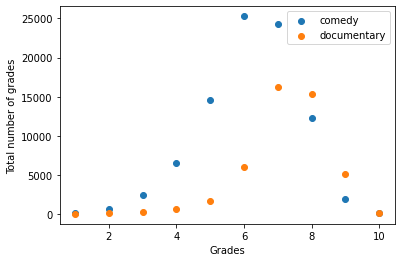

In [7]:
x_comedy = df_comedy.grade
y_comedy = df_comedy.grades_total

x_documentary = df_documentary.grade
y_documentary = df_documentary.grades_total

plt.scatter(x_comedy, y_comedy)
plt.scatter(x_documentary, y_documentary)

plt.xlabel("Grades", fontsize=10)
plt.ylabel("Total number of grades", fontsize=10)

plt.legend(["comedy","documentary"])
plt.show()  

**8. Сохраните результат пункта 6 в базе в новой таблице**

Топ-10 по возрасту

In [8]:
top10_age_query = """
SELECT distinct people.person_id, name, born, died
FROM crew  
    JOIN people ON crew.person_id = people.person_id  
    JOIN role_categories ON crew.category = role_categories.id  
WHERE role_type IN ("actor", "actress") AND died IS NULL AND born NOT NULL AND born >= 1905
ORDER BY born ASC  
LIMIT 10  
"""

In [ ]:
cur.execute("""
CREATE TABLE top10_age (
    person_id INT,
    name TEXT,
    born INT, 
    died INT,
    PRIMARY KEY (person_id)
)
""")
con.commit()

In [10]:
cur.execute(top10_age_query)
data = cur.fetchall()

In [ ]:
cur.executemany("INSERT INTO top10_age VALUES (?, ?, ?, ?)", data)
con.commit()

Список актеров, которые дожили до 100 лет и более

In [12]:
centenarians_query = """
SELECT distinct people.person_id, name, born, died,
IIF(died IS NULL, 2022-born, died - born) as age
FROM crew  
    JOIN people ON crew.person_id = people.person_id  
    JOIN role_categories ON crew.category = role_categories.id  
WHERE role_type IN ("actor", "actress") AND born NOT NULL AND ((died NOT NULL AND died - born >= 100) OR (died IS NULL AND born < 1922))
"""

In [89]:
cur.execute("""
CREATE TABLE centenarians (
    person_id INT,
    name TEXT,
    born INT, 
    died INT,
    age INT,
    PRIMARY KEY (person_id)
)
""")
con.commit()

In [92]:
cur.execute(centenarians_query)
data2 = cur.fetchall()

In [93]:
cur.executemany("INSERT INTO centenarians VALUES (?, ?, ?, ?, ?)", data2)
con.commit()

### Часть 2.

**Доля женщин среди участников фильмов жанра определенного года:**

In [48]:
woman_in_films_query = """
SELECT genre_name, premiered,
	COUNT(IIF(role_type = "actress", 1, NULL)) AS n_woman,
	COUNT(IIF(role_type IN ("actor", "actress"), 1, NULL)) AS n_people,
	CAST(COUNT(IIF(role_type = "actress", 1, NULL)) AS float)/CAST(COUNT(IIF(role_type IN ("actor", "actress"), 1, NULL)) AS float) as w_proportion
FROM crew  
    JOIN people ON crew.person_id = people.person_id  
    JOIN role_categories ON crew.category = role_categories.id  
	JOIN titles ON crew.title_id = titles.title_id 
	JOIN film_genres ON titles.title_id = film_genres.title_id 
	JOIN  film_types ON titles.type = film_types.id  
	JOIN  genre_types ON film_genres.genre_id = genre_types.id  
WHERE film_type = "movie"  AND premiered NOT NULL AND role_type IN ("actor", "actress")
GROUP BY genre_name, premiered
"""

df_women = pd.read_sql_query(woman_in_films_query, con=con)

**Pivot_table по жанрам и годам**

In [45]:
table = pd.pivot_table(df_women, values="w_proportion", index = "premiered", columns = "genre_name", fill_value = 0, margins = True)
table

genre_name,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,All
premiered,,,,,,,,,,,,,,,,,,,,,
1894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.333333,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.333333
1900,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.00000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.166667
1903,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.500000
1906,0.000000,0.000000,0.000000,0.000000,0.500000,0.666667,0.500000,0.00000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.483333
1907,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.222222,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.00000,0.666667,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.541667
2026,0.750000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.437500
2027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


Опираясь на сводную таблицу, можно выявить следующие закономерности:
- мы можем наблюдать некоторое количество нулей в данных вплоть до 2028 года для значительного количества жанров (что может объясняться неполнотой сведений в базе данных)
- судя по строке All, больше всего женских ролей за период с 1894 по 2028 было в фильмах жанра Romance, Family, Adult, Comedy
- в последние годы выросла доля женских ролей в ряде жанров (например, для жанров Sport и Adventure), и эта тенденция продолжается в фильмах, выпуск которых аннонсирован в ближайшие 5 лет
- есть жанры, для которых распределение по гендеру остается практически неизменным (например, жанр Adventure, в котором доля женщин большую часть периода с 1984 по 2028 оставалась между 0.2 и 0.4). В динамике w_proportion для таких жанров есть только редкие "вспышки" - год или несколько лет, в которые вышли фильмы с большой долей женских ролей
- а есть жанры, где всё всегда нестабильно и доля женщин то растет почти до 1, то падает до 0 (как в Reality-TV)
- в стереотипно "женских" жанрах (тех, что, казалось бы, должны больше всего заинтересовать женщин - Family, Romance) доля женщин с каждым годом становится меньше, а в стереотипно "мужских" жанрах (Sport, Adventure) - растёт.

**Визуализация изменения доли женщин в фильмах жанров Comedy, Reality-TB, Sport, Adventure с 1894 по 2028**

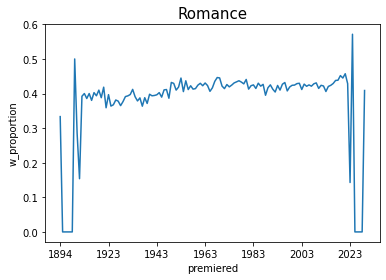

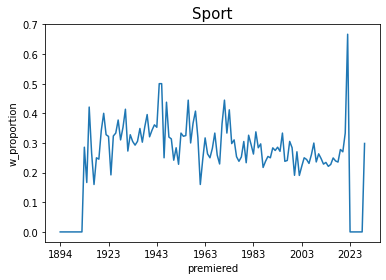

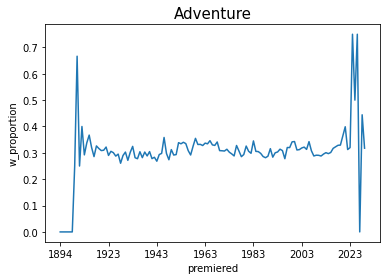

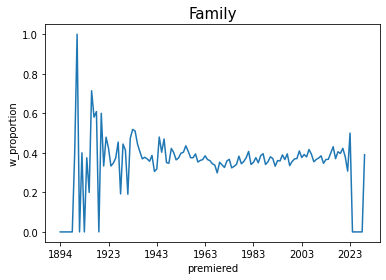

In [69]:
def plt_for_genres(genre_name):
    table[genre_name].plot()
    plt.title(genre_name, fontsize=15)
    plt.ylabel("w_proportion", fontsize=10)
    plt.show()
    
plt_for_genres('Romance')
plt_for_genres('Sport')
plt_for_genres('Adventure')
plt_for_genres('Family')

**Можно ли сделать какие-то выводы об изменениях в индустрии?**

В целом, сравнивая данные 1890-х, начала 20 века и начала 21 века, можно говорить о том, что в фильмах различных жанров доля женщин становится всё больше и больше 

В частности, и графики, и сводная таблица говорят о том, что в кино становится больше репрезентации женщин в стереотипно мужских жанрах, и наоборот - мужчин в женских. Индустрия идет вслед за изменением общества (или предсказывает эти изменения?) и отражает в новых формах то, как по-новому общество воспринимает мужчин и женщин.

### Часть 3.

**1-2. С какими объектами мы работаем? Какие таблицы нужно добавить в базу? Какие параметры нужно хранить? Как эти таблицы связаны между собой и с таблицами, уже имеющимися в базе?**

Мы работаем с личными данными пользователя и данными о его действиях на сайте (а оценивание фильмов - это и есть действия пользователя на сайте). Для того, чтобы хранить такие данные, в базу нужно добавить таблицы grades и users. 

Таблица users будет содержать информацию о пользователях. Она состоит из параметров user_id (айди пользователя), user_name(имя пользователя(логин)), email (почта, указанная при регистрации), password (пароль) и registration_date (дата регистрации пользователя):

users(user_id, user_name, email, password, registration_date)  
1 | hemulitch | hemulitch@yahoo.com | 12345hhh67j | 2018-01-06 05:06:55.186  
2 | mishbar | misha_bar_410@mail.ru | jkll89990jj | 2022-02-24 04:22:58.197  
3 | olesar | olesar@gmail.com | 1234567890qwertyuiop | 2018-09-27 18:35:32.136   
4 | freido | freido@gmail.com | privetmir!228 | 2012-07-12 08:12:11.189  

Запрос на создание таблицы выглядел бы вот так:

CREATE TABLE users (
    user_id INT,
    user_name TEXT,
    email TEXT, 
    password TEXT,
    registration_date TEXT
    PRIMARY KEY (user_id)
)

Таблица grades будет содержать информацию о каждой оценке, которую пользователи ставят какому-то фильму. Для этого в таблицу важно добавить такие параметры как grade_id (уникальный номер этого конкретного действия, т.е. этой оценки этого пользователя этому фильму), title_id (айди фильма, через него можно вывести название фильма), user_id (айди пользователя, по этому параметру можно вывести юзернейм пользователя из таблицы users), grade (оценка фильму title_id), date (когда была поставлена оценка)

grades(grade_id, title_id, grade, user_id, date)  
1 | 80 | 9  | 4 | 2017-11-22 23:40:50.100  
2 | 45 | 5  | 4 | 2017-11-22 23:00:50.178  
3 | 80 | 10 | 1 | 2015-11-01 22:34:58.096  
4 | 89 | 9  | 2 | 2015-06-21 05:04:46.120  

Запрос на создание таблицы выглядел бы вот так:

CREATE TABLE grades (
    grade_id
    title_id INT,
    grade INT,
    user_id INT, 
    date TEXT,
    PRIMARY KEY (grade_id)
)

Между собой эти таблицы будут связаны параметром user_id, и таблица grades также будет связана с таблицей titles по параметру title_id

**3. Нарисуйте схему и прокомментируйте (схему можно положить картинкой в репозиторий или вставить в тетрадку).**

![](https://raw.githubusercontent.com/hse-ling-python/hw3-213-hemulitch/main/Untitled%20Diagram-Page-1.jpg?token=GHSAT0AAAAAAB3HUF7TQFVI2CLV5OZASNSWY35IN6A)

**4. Какие данные нужно будет часто доставать или соединять? Какие индексы в базе хорошо было бы создать, чтобы ползователю было комфортно и быстро получать статистику или какую-то иную информацию. (Представьте, например, свои действия при работе с КиноПоиском или IMDB).**

Индексируется часто первичный ключ, поэтому хорошо было бы создать индексы grade_id (для grades) и user_id (для users). Кроме того, через user_id к таблице users присоединяется таблица grades. Индексируя по user_id, мы ускоряем запрос JOIN users ON grades.user_id = users.user_id
А этот запрос ответственнен за вывод всех оценок пользователя по его user_name

По этой же причине хорошо бы индексировать по titles_id для ускорение запроса JOIN titles ON grades.title_id = titles.title_id
Потому что когда выводишь оценки пользователю по его user_name, к каждой оценке прилагается фильм с определенным названием, информацию о котором можно достать из таблицы titles по titles.id 

Таким образом, для простого просмотра списка фильмов с оценками от определенного пользователя хорошо было проиндексировать то, о чем написано выше



**5. Каких данных не хватает в базе?**

В базе imdb_small_indexed.db не хватает, например, данных о различных наградах, на которые те или иные фильмы/сериалы были номинированы (сколько всего номинаций, сколько выиграли, какие). 
Также было бы здорово добавить в базу данные об отзывах (reviews): количество отзывов у фильма, сколько положительных и сколько отрицательных, сколько user reviews и сколько critic reviews и т.д.